# Detect fraudulent job offers with Pandas and ML

Notebook accompying the Medium post

Data comes from kaggle https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction / http://emscad.samos.aegean.gr/
    

Notebook structure
1. Import libraries and define functions
2. General look at the data
3. Specify questions
4. Exploration, data preprocessing, feature engineering
5. Model

## Import libraries and defined functions:

In [1]:
import numpy as np 
import pandas as pd
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix


In [2]:
sns.set(style="whitegrid")

In [3]:
def find_work_from_home(desc):
    '''looks up bigrams made from strings and returns 1 if there's a remark of work from home in the field
    INPUT: text column with job offer description
    OUTPUT: Returns 1 if text contains bigrams mentioning remote work, else 0'''
    phrases = ['own place','from home', 'work remotely'
                 ,'their homes', 'remote job']
    words = desc.split()
    pairs = [words[i:i + 2] for i in range(len(words))]
    result = [" ".join(pair) for pair in pairs if len(pair) > 1]
    result = [''.join(c for c in s if c not in string.punctuation) for s in result]
    if any(x in phrases for x in result):
        return 1
    else:
        return 0

In [4]:
def signal_phrases(desc):
    ''' INPUT: desc - text column with job offer description
    OUTPUT: Returns 1 if fraud-like phrases (bigrams) are encountered in the text, else 0'''
    
    suspicious = ['free time',  'data entry', 'in hand', 'cash paying',
                  'for everyone', 'get started', 'become wealthy', 'pay daily'
                  , 'make money', 'online job']
    words = desc.split()
    pairs = [words[i:i + 2] for i in range(len(words))]
    result = [" ".join(pair) for pair in pairs if len(pair) > 1]
    result = [''.join(c for c in s if c not in string.punctuation) for s in result]
    if any(x in suspicious for x in result):
        return 1
    else:
        return 0

In [5]:
def find_links(desc):
    '''INPUT: desc - text column with job offer description
    OUTPUT: Number of URLs found in the description field (URLs have been encoded in the dataset as #url)'''
    links = re.findall(r'(#url_\S+)', desc)
    return len(links)


In [6]:
def find_email(desc):
    '''INPUT:text column with job offer description
    OUTPUT: Number of email addresses found in the description field (Emails have been encoded in the dataset as #email)'''
    email = re.findall(r'(#email_\S+)',desc)
    return len(email)

In [7]:
def categorical_nans(columns, df, na_replacement="unknown"):
    """INPUT: 
        df : Pandas DataFrame
        columns: categorical columns to handle
        na_replacement: value for NA
        Output:
        df : preprocessed Pandas DataFrame """
    for col in columns:
        if df.dtypes[col]=="object":
            df[col]=df[col].fillna(na_replacement)
    return df
    

In [8]:
def higher_ed(formal_ed_str):
    '''
    INPUT:formal_ed_str - a string of one of the values from the Formal Education column
    OUTPUT: return 1 if the string is  in ("Master's degree", "Doctoral", "Professional degree")
        return 0 otherwise
    
    '''
    if formal_ed_str in ("Associate Degree", "Bachelor's Degree", "Master's Degree", "Professional", "Doctorate"):
        return 1
    else:
        return 0
    

In [9]:
def create_dummy_df(df, cat_cols):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)
        except:
            continue
    return df

In [11]:
filename = 'real-or-fake-fake-jobposting-prediction.zip'


In [12]:
job_data = pd.read_csv(os.getcwd()+'/'+filename)

## First peek at the data

In [13]:
job_data.shape

(17880, 18)

In [14]:
job_data.head(20)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [15]:
job_data.company_profile[1]

'90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, L’Oreal, Sony and Barclays and has offices in Auc

In [16]:
job_data.groupby("fraudulent").count()['job_id'].rename(columns={"job_id":"count"})

fraudulent
0    17014
1      866
dtype: int64

First, let's take a look at the job adverts that are marked as "fraudulent".
Example fraudulent offers:

In [17]:
sample_frauds =job_data[job_data['fraudulent'] == 1].sample(50).reset_index(drop=True)
sample_frauds

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,17638,Cruise Staff Wanted *URGENT*,"US, IL, CHICAGO",NaN,NaN,NaN,6* Ultra Luxury American Cruise Company is urg...,Certification &amp; Experience: Previous exper...,Benefits: On board en suite accommodation and ...,0,0,1,Full-time,NaN,NaN,"Leisure, Travel & Tourism",NaN,1
1,17570,"CASH JOBS, Part Time Workers Needed.","AU, NSW, Sydney",NaN,NaN,NaN,"CASH JOBS, Part Time Workers Needed.Work Minim...",Work Minimum 1-2 Hours Per Day Anytime.,Suitable For Both Male And Female.,0,0,0,Part-time,NaN,NaN,NaN,NaN,1
2,2078,Piping Material Engineer,"US, TX, Houston",NaN,NaN,Aker Solutions is a global provider of product...,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributes• High...,NaN,0,1,0,Full-time,Mid-Senior level,Master's Degree,Oil & Energy,Engineering,1
3,17653,Clerical Assistant,"US, NY, ALBANY",Admin/Clerical,40000-60000,NaN,The Clerical Assistant will be responsible for...,"Who we're Looking For:- Motivated, detail orie...",This is a full-time salary position that offer...,0,0,0,Full-time,Not Applicable,High School or equivalent,Civil Engineering,Administrative,1
4,7184,CUSTOMER SERVICE AGENT,"US, TX, DALLAS",CALL CENTER SP,30000-38000,Aegis is a global business services provider i...,"Location DALLAS, TX , USAJob DescriptionRepres...",HIGH SCHOOL DIPLOMA,"HEALTH CARE,DENTAL INSURANCE, LIFE INSURANCE, ...",0,1,1,Full-time,Entry level,High School or equivalent,Consumer Services,Customer Service,1
5,17693,Administrative Assistant,"US, ,",ADMIN,34000-42000,NaN,Administrative AssistantEssential Duties and R...,Qualification/Requirements: * Proficient in Mi...,"Health, Dental, Life and AD&amp;D Insurance, E...",0,0,0,Full-time,Entry level,NaN,Accounting,Administrative,1
6,11539,Research Engineer Data Science,"US, CA, San Mateo",Engineering,NaN,Aptitude Staffing Solutions has redesigned the...,"Research Engineer | Data Science | San Mateo, ...",Position requirements: Quickly learning new ar...,The BenefitsGenerous paid time off to help you...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Marketing and Advertising,Engineering,1
7,1701,Cruise Staff Wanted *URGENT*,"US, NY, MANHATTAN",NaN,NaN,NaN,6* Ultra Luxury American Cruise Company is urg...,Certification &amp; Experience: Previous exper...,Benefits: On board en suite accommodation and ...,0,0,0,Full-time,NaN,NaN,"Leisure, Travel & Tourism",NaN,1
8,17747,Network Marketing,"US, CA,",NaN,7200-1380000,NaN,"Are you looking to make anywhere from 600-115,...","An ambition to succeed, A desire to be the bes...","Residual Income, Travel dollars, Car Dollars, ...",0,0,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,NaN,1
9,4578,Senior Sales Professionals,"US, IN, Indianapolis",Sales/Marketing,NaN,NaN,Do YOU have the sales skills or entrepreneuria...,NaN,NaN,0,0,0,NaN,NaN,High School or equivalent,NaN,Sales,1


In [18]:
sample_frauds.description[19]

'Well Paid Cash Jobs To Start Immediately. No Experience Required And Never Any Fees.Work Anytime 1 To 2 Hrs Daily In Free Time.Earn Easily $350 To $400 Extra Per Day.Totally Free To Join &amp; Suitable For All.Take Action &amp; Get Started Here:-#URL_7045495b1ed4944c22f2b385d32cd015de8d94e25f1d4a6232fa3139286ffdd9#'

In [19]:
sample_frauds.description[11]

'Fast paced company in need of both Full-Part time, Executive Assistant. Must be computer literate, highly organized, able to deal with high stress situations, and have excellent negotiating skills. Also must have accounting,customer service and data entry background.Duties include but are not limited to:-Receiving all clients and visitors-answering phones and email correspondence-coordinating/managing schedules for several -therapists at one time-data entry-filing and sorting-copying and faxing, running errands-Assisting the customer service area as well.'

The job description field looks fairly authentic for most of the fraud offers. From the examination of this variable for a subset of frauds the function "signal_phrases()" has been created to flag the offers which contain some 'fraud-looking' bigrams.

## Questions to answer with the data

1. In which country are offered the highest salaries?
2. Do fraudulent job listings offer higher salary than real ones?
3. Which country has the largest ratio of fraudulent job adverts?
4. What types of employment do the scammers prefer?
5. Is it possible to create an accurate classification model to detect scam job offers with simple feature engineering?

## Exploration, data cleaning and new features

a) check for missing values

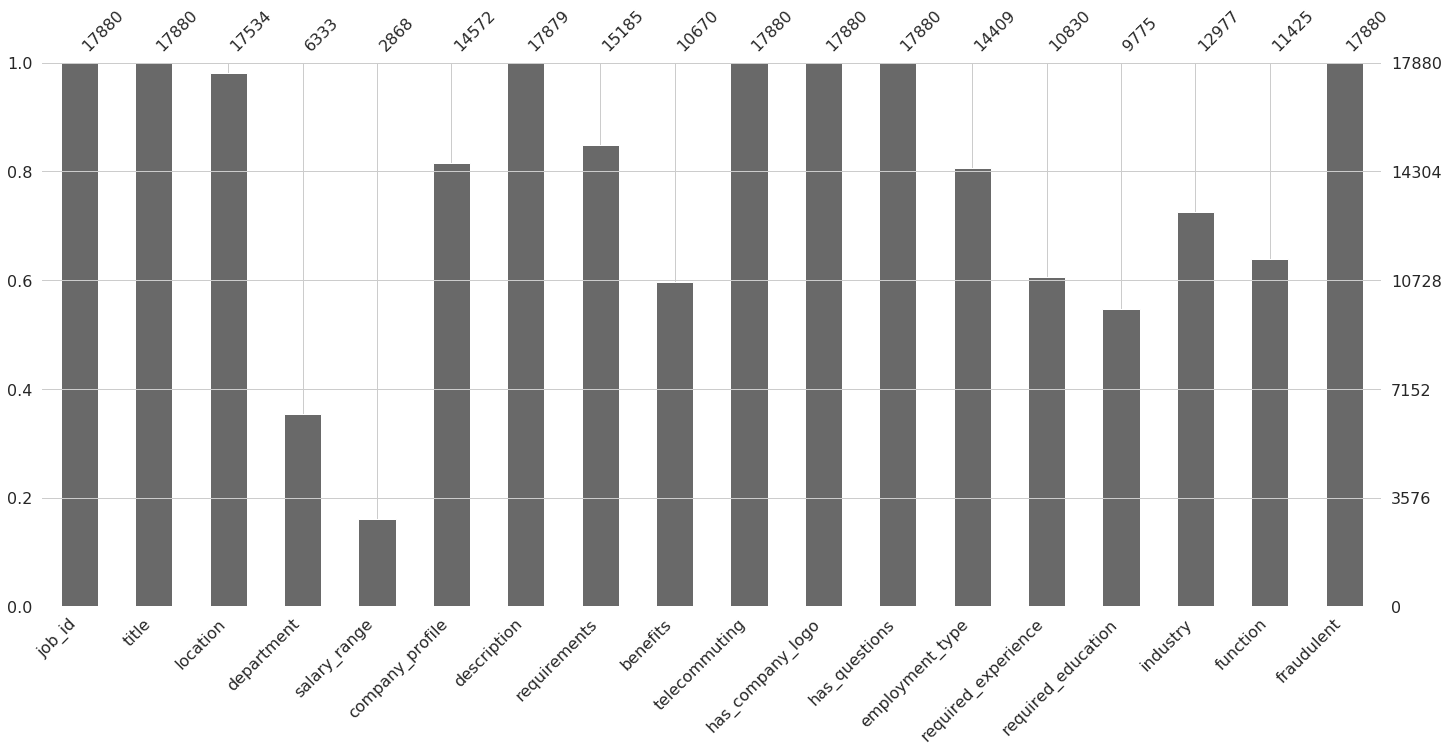

In [20]:
msno.bar(job_data) 

b) Check for duplicates  & add feature depicting number of postings and removal of duplicate job listings 

In [21]:
job_data["country"] = job_data[job_data['location'].notnull()]["location"].apply(lambda x: x.split(',')[0])


job_data_cleaned_cats = categorical_nans(["department","company_profile", "description", "requirements", "benefits", "employment_type"
                            , "required_experience", "required_education", "industry", "function", "country"], df=job_data)


In [22]:

job_data_cleaned_cats['name'] = job_data_cleaned_cats['fraudulent'].map(str).str.cat(others=[job_data_cleaned_cats.title, job_data_cleaned_cats.country, job_data_cleaned_cats.department, job_data_cleaned_cats.requirements], sep='_')

dups = job_data_cleaned_cats.groupby(['name']).count()["job_id"].sort_values( ascending = False).reset_index()
dups.columns = ['name', 'number_offers']
dups.head(10)

,name,number_offers
0,0_English Teacher Abroad _US_unknown_Universit...,295
1,0_Graduates: English Teacher Abroad (Conversat...,144
2,0_English Teacher Abroad_US_unknown_University...,89
3,0_Beauty & Fragrance consultants needed_GB_unk...,58
4,0_English Teacher Abroad (Conversational)_US_u...,42
5,0_Graduates: English Teacher Abroad _US_unknow...,38
6,0_Customer Service Associate _US_unknown_Minim...,31
7,0_Entry Level Sales_US_unknown_unknown,26
8,0_English Teacher Abroad (Conversational)_US_u...,25
9,1_Data Entry Admin/Clerical Positions - Work F...,21


In [23]:
#job_data.join(dups.astype(str), on="name", how="left")

job_data_cleaned_cats = job_data_cleaned_cats.merge(dups, on = "name", how="left")

In [24]:
job_data_cleaned_cats = job_data_cleaned_cats.drop_duplicates(subset=["title", "country", "department", "requirements"], keep="first")
job_data_cleaned_cats = job_data_cleaned_cats.drop(columns=["name"])

print("After removing duplicates we are left out with", job_data_cleaned_cats.shape[0], "rows.")

After removing duplicates we are left out with 15244 rows.


In [25]:
job_data_cleaned_cats.groupby(["number_offers"]).count()["job_id"].rename({"job_id":"count"}) 


number_offers
1      14400
2        551
3        114
4         46
5         28
6         17
7         15
8          6
9          5
10        20
11        10
12         4
13         6
14         2
15         2
16         2
17         2
18         1
19         1
21         3
25         1
26         1
31         1
38         1
42         1
58         1
89         1
144        1
295        1
Name: job_id, dtype: int64

One job ad was posted 295 times.

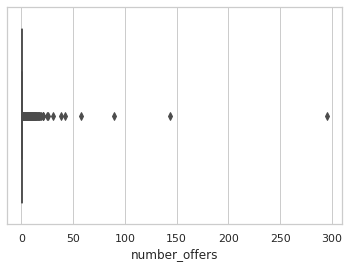

In [26]:
sns.boxplot("number_offers", data=job_data_cleaned_cats)

c) extract further features

In [27]:
job_data_cleaned_cats.drop(columns =["location"], inplace = True)

A dictionary to convert currencies to USD, exchange rate as of 10.04.2020
> countries (keys in currency_rates): list(job_data["country"].unique())

In [28]:
currency_rates = {'US' : 1, 'NZ' : 0.61, 'DE' : 1.09, 'GB' : 1.24, 'AU' : 0.63, 'SG' : 0.71, 'IL' : 0.28, 'AE' : 0.27,
 'CA' : 0.72, 'IN' : 0.013, 'EG' : 0.063, 'PL' : 0.24, 'GR' : 1.09, 'PK' : 0.0060, 'BE' : 1.09, 'BR' : 0.20,
 'SA' : 0.27, 'DK' : 0.15, 'RU' : 0.014, 'ZA' : 0.055, 'CY' : 1.09, 'HK' : 0.13,  'TR' : 0.15, 'IE' : 1.09,
 'LT' : 1.09, 'JP' : 0.0092, 'NL' : 1.09, 'AT' : 1.09, 'KR' : 0.00083, 'FR' : 1.09, 'EE' : 1.09, 'TH' : 0.031,
 'PA' : 1.01, 'KE' : 0.00938327, 'MU' : 0.025, 'MX' : 0.043, 'RO' : 0.23, 'MY' : 0.00071, 'FI' : 1.09, 'CN' : 0.14, 'ES' : 1.09,
 'SE' : 0.10, 'CL' : 0.0012, 'UA' : 0.037, 'QA' : 0.27, 'IT' : 1.09, 'LV' : 1.09, 'IQ' : 0.00084, 'BG' : 0.56, 'PH' : 0.020, 'CZ' : 0.040, 'VI' : 1,
 'MT' : 1.09, 'HU' : 0.0031, 'BD' : 0.012, 'KW' : 3.22, 'LU' : 1.09, 'NG' : 0.0026, 'RS' : 0.0093,
 'BY' : 0.40, 'VN' : 0.000043, 'ID' : 0.000063, 'ZM' : 0.054, 'NO' : 0.0977137, 'BH' : 2.65, 'UG' : 0.00027,
 'CH' : 1.04, 'TT' : 0.15, 'SD' : 0.018, 'SK' : 1.09, 'AR' : 0.015, 'TW' : 0.033, 'PT' : 1.09, 'PE' : 0.297159,
 'CO' : 0.00026, 'IS' : 0.0070, 'SI' : 1.09, 'MA' : 0.0973810, 'AM' : 0.0020, 'TN' : 0.35, 'GH' : 0.17, 'AL' : 0.00860442,
 'HR' : 0.14, 'CM' : 0.00164, 'SV' : 0.11, 'NI' : 0.029, 'LK' : 0.0053, 'JM' : 0.0074, 'KZ' : 0.0023, 'KH' : 0.00025}

In [29]:
job_data_cleaned_cats["description"] = job_data_cleaned_cats[job_data_cleaned_cats['description'].notnull()]["description"].apply(lambda x: x.lower())
job_data_cleaned_cats["title_length"] = job_data_cleaned_cats["title"].apply(lambda x: len(x.split()))
job_data_cleaned_cats["desc_length"] = job_data_cleaned_cats[job_data_cleaned_cats['description'].notnull()]["description"].apply(lambda x: len(x.split()))
job_data_cleaned_cats['company_profile_length'] = job_data_cleaned_cats[job_data_cleaned_cats['company_profile'].notnull()]["company_profile"].apply(lambda x: len(x.split()))
job_data_cleaned_cats['requirements_length'] = job_data_cleaned_cats[job_data_cleaned_cats['requirements'].notnull()]["requirements"].apply(lambda x: len(x.split()))


In [30]:
#split salary_range info into multiple features
salary_temp = job_data_cleaned_cats[job_data_cleaned_cats['salary_range'].notnull()]["salary_range"].str.split("-", n = 1, expand = True) 
job_data_cleaned_cats["salary_lower_cap"]  = pd.to_numeric(salary_temp[0], errors='coerce')
job_data_cleaned_cats["salary_upper_cap"]  = pd.to_numeric(salary_temp[1], errors='coerce')

job_data_cleaned_cats.drop(columns =["salary_range"], inplace = True)


In [31]:
job_data_cleaned_cats["salary_avg"] =job_data_cleaned_cats[['salary_lower_cap', 'salary_upper_cap']].mean(axis=1).round()

Convert the currencies to USD using mapping dictionary from above.

In [32]:
job_data_cleaned_cats["salary_avg_usd"] = job_data_cleaned_cats[job_data_cleaned_cats['salary_avg'].notnull()]["salary_avg"] * job_data_cleaned_cats[job_data_cleaned_cats['salary_avg'].notnull()]["country"].map(currency_rates)

In [33]:
job_data_cleaned_cats["salary_spread"] = (job_data_cleaned_cats["salary_upper_cap"] - job_data_cleaned_cats["salary_lower_cap"])/job_data_cleaned_cats["salary_upper_cap"]
job_data_cleaned_cats.drop(columns =["salary_upper_cap", 'salary_lower_cap', 'salary_avg'], inplace = True)


In [34]:
job_data_cleaned_cats["salary_spread"].describe()

count    2478.000000
mean        0.280678
std         0.200888
min         0.000000
25%         0.153846
50%         0.235294
75%         0.357143
max         1.000000
Name: salary_spread, dtype: float64

In [35]:
job_data_cleaned_cats["mentions_benefits"] = job_data_cleaned_cats["benefits"].apply(lambda x: 0 if pd.isnull(x) else 1)

In [36]:
#apply defined functions

job_data_cleaned_cats['url_in_desc'] = job_data_cleaned_cats['description'].apply(find_links)
job_data_cleaned_cats['email_in_desc'] = job_data_cleaned_cats['description'].apply(find_email)
job_data_cleaned_cats['fraudlike_phrases'] = job_data_cleaned_cats['description'].apply(signal_phrases)
job_data_cleaned_cats['work_from_home_desc'] = job_data_cleaned_cats['description'].apply(find_work_from_home)
 

In [37]:
job_data_cleaned_cats.groupby(["fraudlike_phrases", "fraudulent"]).agg("count")["job_id"].groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

fraudlike_phrases  fraudulent
0                  0             96.243220
                   1              3.756780
1                  0             64.630225
                   1             35.369775
Name: job_id, dtype: float64

fraudlike_phrases occur 11 times more frequently in fraudulent job offers than in real offers.

In [38]:
job_data_cleaned_cats["higher_degree_required"] = job_data_cleaned_cats["required_education"].apply(higher_ed)

In [39]:
job_data_cleaned_cats.groupby(["higher_degree_required", "fraudulent"]).agg("count")["job_id"].rename({"job_id":"count"})

higher_degree_required  fraudulent
0                       0             9705
                        1              558
1                       0             4868
                        1              113
Name: job_id, dtype: int64

frauds can be over two times more frequently found among jobs that don't require higher degree.

In [40]:
job_data_cleaned_cats.isna().sum()

job_id                        0
title                         0
department                    0
company_profile               0
description                   0
requirements                  0
benefits                      0
telecommuting                 0
has_company_logo              0
has_questions                 0
employment_type               0
required_experience           0
required_education            0
industry                      0
function                      0
fraudulent                    0
country                       0
number_offers                 0
title_length                  0
desc_length                   0
company_profile_length        0
requirements_length           0
salary_avg_usd            12629
salary_spread             12766
mentions_benefits             0
url_in_desc                   0
email_in_desc                 0
fraudlike_phrases             0
work_from_home_desc           0
higher_degree_required        0
dtype: int64

In [41]:
job_data_cleaned_cats.select_dtypes(include=["object"]).apply(lambda x : len(x.value_counts()))


title                  11231
department              1338
company_profile         1708
description            14070
requirements           11969
benefits                6117
employment_type            6
required_experience        8
required_education        14
industry                 132
function                  38
country                   91
dtype: int64

In [42]:
sum(job_data_cleaned_cats['function'].map(job_data_cleaned_cats['function'].value_counts(normalize=True)) < 0.005)

482

Encode rare categories as rest to 
1) Improve readability of aggregations and plots
2) prevent overfitting of model
3) to impute missing in remaining numerics by the mean of the group the row belongs to.


In [43]:
#encode rare categories as rest to 1) prevent overfitting of model and 2) to impute missing in certain numerics by the mean of the group the row belongs to
#handy oneliner by Maya Gilad https://medium.com/gett-engineering/handling-rare-categorical-values-in-pandas-d1e3f17475f0
#replace with "Other" all the countries that are in less than 0.5% of the dataset
job_data_cleaned_cats['country'] = job_data_cleaned_cats['country'].mask(job_data_cleaned_cats['country'].map(job_data_cleaned_cats['country'].value_counts(normalize=True)) < 0.01, 'Other')
job_data_cleaned_cats['function'] = job_data_cleaned_cats['function'].mask(job_data_cleaned_cats['function'].map(job_data_cleaned_cats['function'].value_counts(normalize=True)) < 0.01, 'Other')
job_data_cleaned_cats['industry'] = job_data_cleaned_cats['industry'].mask(job_data_cleaned_cats['industry'].map(job_data_cleaned_cats['industry'].value_counts(normalize=True)) < 0.01, 'Other')
job_data_cleaned_cats['country'].value_counts()


US         8361
GB         2192
Other      1845
GR          927
CA          409
DE          377
unknown     340
NZ          321
IN          263
AU          209
Name: country, dtype: int64

Most job offers come from the US followed by Great Britain and Greece.

In [44]:
job_data_cleaned_cats['function'].value_counts()


unknown                   5059
Other                     1848
Information Technology    1680
Engineering               1291
Sales                     1270
Customer Service           924
Marketing                  785
Administrative             554
Design                     332
Health Care Provider       296
Management                 261
Business Development       210
Accounting/Auditing        207
Human Resources            191
Project Management         179
Finance                    157
Name: function, dtype: int64

In [45]:
job_data_cleaned_cats['industry'].value_counts()


unknown                                4288
Other                                  4237
Information Technology and Services    1633
Computer Software                      1273
Internet                               1036
Marketing and Advertising               731
Financial Services                      567
Hospital & Health Care                  438
Telecommunications                      299
Consumer Services                       276
Oil & Energy                            254
Retail                                  212
Name: industry, dtype: int64

In [46]:
job_data_cleaned_cats["salary_avg_usd"].describe().apply("{0:.2f}".format)

count       2615.00
mean       61282.69
std       312852.61
min            0.00
25%        17765.00
50%        40000.00
75%        65000.00
max      8325000.00
Name: salary_avg_usd, dtype: object

In [47]:
job_data_cleaned_cats[job_data_cleaned_cats['salary_avg_usd'] == 8325000.00]

,job_id,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,company_profile_length,requirements_length,salary_avg_usd,salary_spread,mentions_benefits,url_in_desc,email_in_desc,fraudlike_phrases,work_from_home_desc,higher_degree_required
7651,7652,Sr. Java Architect,unknown,unknown,as a sr. java architect you will play an impor...,Requirements 10+ years hands on experience wit...,Full Benefits and Bonus. Fast Growing Company.,0,0,0,...,1,71,8325000.0,0.990909,1,0,0,0,0,1


Takeaway: Learn Java!

On a serious note, this must be an outlier, let's check that via boxplot and then assign missing values to them. 

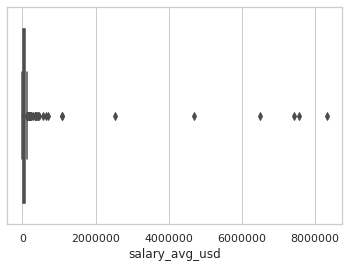

In [48]:
sns.boxplot(x=job_data_cleaned_cats["salary_avg_usd"], showfliers = True)

Replace numeric outliers (less than 1000 USD or more than 1 million USD) with NANs, they'll be imputed few code blocks later


In [49]:

job_data_cleaned_cats["salary_avg_usd"] =job_data_cleaned_cats["salary_avg_usd"].mask((job_data_cleaned_cats["salary_avg_usd"] < 1000 ) | (job_data_cleaned_cats["salary_avg_usd"] > 1000000))
job_data_cleaned_cats["salary_spread"] = job_data_cleaned_cats["salary_spread"].mask((job_data_cleaned_cats["salary_avg_usd"] < 1000 ) | (job_data_cleaned_cats["salary_avg_usd"] > 1000000))



In [50]:
job_data_cleaned_cats["salary_avg_usd"].describe().apply("{0:.2f}".format)

count      2230.00
mean      54280.40
std       45842.97
min        1000.00
25%       27900.00
50%       45000.00
75%       69300.00
max      693600.00
Name: salary_avg_usd, dtype: object

693k sounds like a nice amount...

In [51]:
job_data_cleaned_cats[job_data_cleaned_cats['salary_avg_usd'] == 693600.00][["title","description", "fraudulent"]]

,title,description,fraudulent
5687,Network Marketing,"are you looking to make anywhere from 600-115,...",1


It's a fraud!

Text(0.5, 1.0, 'Range of offered salaries')

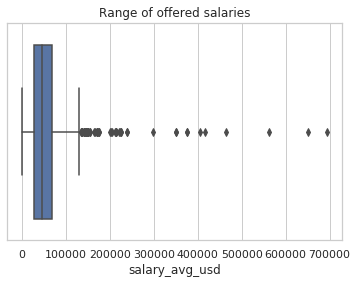

In [52]:
sns.boxplot(x=job_data_cleaned_cats["salary_avg_usd"], showfliers = True).set_title('Range of offered salaries')

Still some outliers left but for the analysis of fraudulent job postings they might be relevant, as maybe it's one of the way scammers want to attract new victims.

In [53]:
job_data_cleaned_cats.groupby(["country", "industry", "function", "fraudulent"]).mean()["salary_avg_usd"]

country  industry           function                fraudulent
AU       Computer Software  Information Technology  0             43050.0
                            Marketing               0                 NaN
                            Project Management      0             69300.0
                            Sales                   0                 NaN
         Consumer Services  Administrative          1             26775.0
                                                                   ...   
unknown  unknown            Marketing               0                 NaN
                            Other                   0                 NaN
                            Sales                   0                 NaN
                            unknown                 0                 NaN
                                                    1                 NaN
Name: salary_avg_usd, Length: 973, dtype: float64

In [54]:
job_data_cleaned_cats["salary_avg_usd"].mean()

54280.39708385651

Next, let's impute thousands of missing salary info - as a proxy the average for each combination of country, industry, function, type of employment and fraud-decision the missing observation belongs to. If there was not a group like that from which the data could be used, imputer goes one 'level' higher.

In [55]:

job_data_cleaned_cats["salary_avg_usd"] = job_data_cleaned_cats.groupby(["country", "industry","function","employment_type", "fraudulent"]).transform(lambda x: x.fillna(x.mean()))["salary_avg_usd"]
job_data_cleaned_cats["salary_avg_usd"] = job_data_cleaned_cats.groupby(["country", "industry","employment_type", "fraudulent"]).transform(lambda x: x.fillna(x.mean()))["salary_avg_usd"]
job_data_cleaned_cats["salary_avg_usd"] = job_data_cleaned_cats.groupby(["country", "employment_type", "fraudulent"]).transform(lambda x: x.fillna(x.mean()))["salary_avg_usd"]
job_data_cleaned_cats["salary_avg_usd"] = job_data_cleaned_cats.groupby(["country", "industry", "fraudulent"]).transform(lambda x: x.fillna(x.mean()))["salary_avg_usd"]
job_data_cleaned_cats["salary_avg_usd"] = job_data_cleaned_cats.groupby(["country", "fraudulent"]).transform(lambda x: x.fillna(x.mean()))["salary_avg_usd"]


In [56]:
job_data_cleaned_cats["salary_avg_usd"].isna().sum()

343

For 343 rows it was not possible to deduct salary, thus these cases will be removed.

In [57]:
job_data_cleaned_cats["salary_avg_usd"].describe()

count     14901.000000
mean      58919.234484
std       44629.317720
min        1000.000000
25%       30021.802971
50%       46318.181818
75%       80000.000000
max      693600.000000
Name: salary_avg_usd, dtype: float64

As a result of imputation based on country, industry and function the median salary offered among all countries rose from 45k to 46.3k.

In [58]:
#job_data_cleaned_cats= job_data_cleaned_cats.fillna(-1)

In [59]:
job_data_cleaned_cats.isna().sum()

job_id                        0
title                         0
department                    0
company_profile               0
description                   0
requirements                  0
benefits                      0
telecommuting                 0
has_company_logo              0
has_questions                 0
employment_type               0
required_experience           0
required_education            0
industry                      0
function                      0
fraudulent                    0
country                       0
number_offers                 0
title_length                  0
desc_length                   0
company_profile_length        0
requirements_length           0
salary_avg_usd              343
salary_spread             12766
mentions_benefits             0
url_in_desc                   0
email_in_desc                 0
fraudlike_phrases             0
work_from_home_desc           0
higher_degree_required        0
dtype: int64

In [60]:
job_data_cleaned_cats = job_data_cleaned_cats.dropna(subset=["salary_avg_usd"])
print("Finally we're left out with", job_data_cleaned_cats.shape[0],"job adverts")

Finally we're left out with 14901 job adverts


In [61]:
#remaining numeric nans (salary spread) to -999
job_data_cleaned_cats= job_data_cleaned_cats.fillna(-999)

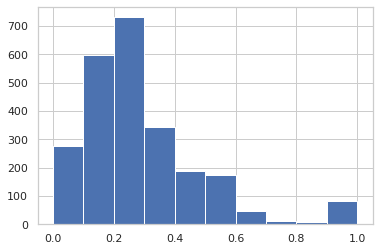

In [62]:
job_data_cleaned_cats[job_data_cleaned_cats["salary_spread"] != -999]["salary_spread"].hist()

In [63]:
#discretizing salary_spread
job_data_cleaned_cats["salary_spread_cat"] = ['no spread' if x == 0 else 'low' if x <= 0.20 else 'mid' if x <= 0.40 else 'high' if x <=1 else np.nan for x in job_data_cleaned_cats['salary_spread']]

# Analysis

### Question 1: Which countries pay the most? (denominated in USD, nominal value, only real offers)

In [64]:
job_data_cleaned_cats.where(job_data_cleaned_cats["fraudulent"]==0).groupby("country").agg({"salary_avg_usd": "median", "job_id": "count"}).sort_values("salary_avg_usd", ascending = False).rename(columns={"salary_avg_usd":"median salary in usd", "job_id":"number of job offers"})

,median salary in usd,number of job offers
country,,
US,71650.000000,7810
NZ,49089.858156,321
DE,46926.736138,377
AU,45675.000000,171
CA,37369.163077,398
GB,33273.333333,2178
GR,23135.250000,927
Other,17903.125000,1810
IN,5634.164364,260


Answer: Countries like the US, New Zealand and Germany

### Question 2: Which countries have the highest ratio of fake offers?

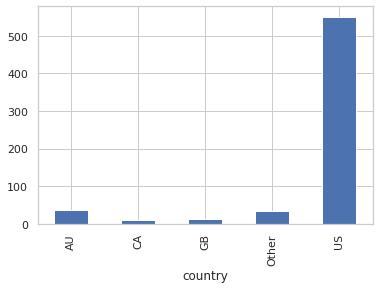

In [65]:

job_data_cleaned_cats[job_data_cleaned_cats["fraudulent"]==1].groupby("country")["job_id"].count().plot(kind="bar" )

In [66]:
df = job_data_cleaned_cats.groupby(["country", "fraudulent"], as_index=False)["job_id"].count().rename(columns={"job_id":"count"})
df

,country,fraudulent,count
0,AU,0,171
1,AU,1,38
2,CA,0,398
3,CA,1,11
4,DE,0,377
5,GB,0,2178
6,GB,1,14
7,GR,0,927
8,IN,0,260
9,NZ,0,321


In [67]:
pivot = df.pivot_table(index='country',columns='fraudulent',aggfunc=sum)
pivot

count       
fraudulent       0      1
country                  
AU           171.0   38.0
CA           398.0   11.0
DE           377.0    NaN
GB          2178.0   14.0
GR           927.0    NaN
IN           260.0    NaN
NZ           321.0    NaN
Other       1810.0   35.0
US          7810.0  551.0

In [68]:
pivot["fraud_ratio"] = (pivot["count"][1]/(pivot["count"][0]+pivot["count"][1])).fillna(0)

In [69]:
pivot=pivot.reset_index().sort_values(by="fraud_ratio", ascending = False)
pivot

country   count        fraud_ratio
fraudulent               0      1            
0               AU   171.0   38.0    0.181818
8               US  7810.0  551.0    0.065901
1               CA   398.0   11.0    0.026895
7            Other  1810.0   35.0    0.018970
3               GB  2178.0   14.0    0.006387
2               DE   377.0    NaN    0.000000
4               GR   927.0    NaN    0.000000
5               IN   260.0    NaN    0.000000
6               NZ   321.0    NaN    0.000000

Almost one in 5 job offers from Australia were fraudulent! 
The ratio for the United States equals approx. 7%, but the sample size exceeds the other countries combined.

Germany, Greece, India and New Zealand all have no fraudulent offers in the dataset.

Text(0.5, 1.0, 'Ratio of fraudulent job offers by country')

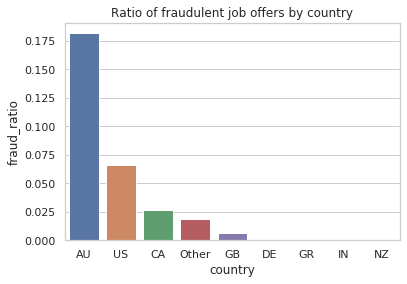

In [70]:
sns.barplot(x="country", y="fraud_ratio", data=pivot).set_title('Ratio of fraudulent job offers by country')

### Question 3: Do fraudulent US job listings offer higher salary than real ones?

I'll select just the US because of its frequency in the data, by far exceeding all the other countries.

In [71]:
job_data_cleaned_cats[job_data_cleaned_cats['country'] ==  "US"].groupby("fraudulent").mean()["salary_avg_usd"].round()

fraudulent
0    80920.0
1    58401.0
Name: salary_avg_usd, dtype: float64

In [72]:
job_data_cleaned_cats[job_data_cleaned_cats['country'] ==  "US"].groupby("fraudulent").median()["salary_avg_usd"].round()

fraudulent
0    71650.0
1    45385.0
Name: salary_avg_usd, dtype: float64

In fact, the opposite is true - the average salary of a fraudulent job is over $22000 lower than for a real job. It can depend also on the various kinds of employment. Let's check that for all available employment types.


In [73]:
job_data_cleaned_cats[(job_data_cleaned_cats['country'] ==  "US") & (job_data_cleaned_cats['employment_type'] == "Other" )].groupby("fraudulent").mean()["salary_avg_usd"]

fraudulent
0    31898.617886
1    66652.329725
Name: salary_avg_usd, dtype: float64

In [74]:
for emptype in job_data_cleaned_cats['employment_type'].unique():
    print("Average salary of job offers in the US for", emptype, "employment type")
    print("Real:", job_data_cleaned_cats[(job_data_cleaned_cats['country'] ==  "US") & (job_data_cleaned_cats['employment_type'] == emptype )].groupby("fraudulent").mean()["salary_avg_usd"].round()[0], "USD" )
    print("Fraud:", job_data_cleaned_cats[(job_data_cleaned_cats['country'] ==  "US") & (job_data_cleaned_cats['employment_type'] == emptype )].groupby("fraudulent").mean()["salary_avg_usd"].round()[1], "USD" )
    print("_____________________________________________________________________________________________")


Average salary of job offers in the US for Other employment type
Real: 31899.0 USD
Fraud: 66652.0 USD
_____________________________________________________________________________________________
Average salary of job offers in the US for Full-time employment type
Real: 69833.0 USD
Fraud: 63899.0 USD
_____________________________________________________________________________________________
Average salary of job offers in the US for unknown employment type
Real: 150470.0 USD
Fraud: 48745.0 USD
_____________________________________________________________________________________________
Average salary of job offers in the US for Part-time employment type
Real: 24616.0 USD
Fraud: 24424.0 USD
_____________________________________________________________________________________________
Average salary of job offers in the US for Contract employment type
Real: 72320.0 USD
Fraud: 65171.0 USD
_____________________________________________________________________________________________
Averag

Only for "temprary" and "other" type of employment this rule holds true. Especially huge difference is in case of "unknown" employment type (no input in source data), where real job adverts offer salary 3 times as big as the fraudulent ones.


In [75]:
df= job_data_cleaned_cats[job_data_cleaned_cats['country'] ==  "US"].groupby(['employment_type', 'fraudulent'], as_index=False)["salary_avg_usd"].mean().round()
df

,employment_type,fraudulent,salary_avg_usd
0,Contract,0,72320.0
1,Contract,1,65171.0
2,Full-time,0,69833.0
3,Full-time,1,63899.0
4,Other,0,31899.0
5,Other,1,66652.0
6,Part-time,0,24616.0
7,Part-time,1,24424.0
8,Temporary,0,10755.0
9,Temporary,1,34458.0


Text(0.5, 1, 'Average salary of US jobs by employment type')

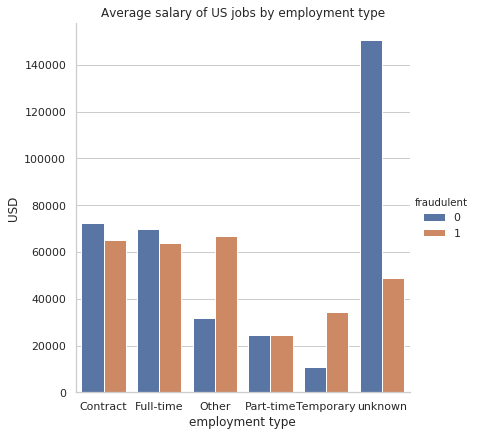

In [76]:
sns.catplot(x="employment_type", y="salary_avg_usd", hue="fraudulent", data=df,
                height=6, kind="bar").set_xlabels("employment type").set_ylabels("USD")
plt.title('Average salary of US jobs by employment type')

Text(0.5, 1, 'Median salary of US jobs by employment type')

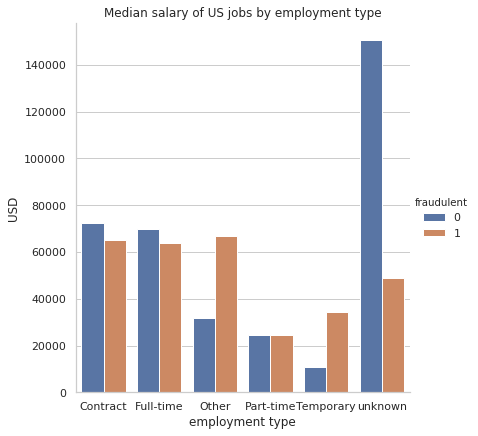

In [77]:
sns.catplot(x="employment_type", y="salary_avg_usd", hue="fraudulent", data=df,
                height=6, kind="bar", estimator = np.median).set_xlabels("employment type").set_ylabels("USD")
plt.title('Median salary of US jobs by employment type')


In [78]:
job_data_cleaned_cats[(job_data_cleaned_cats['country'] ==  "US") & (job_data_cleaned_cats['employment_type'] != "unknown")].groupby("fraudulent").mean()["salary_avg_usd"].round()

fraudulent
0    65491.0
1    61061.0
Name: salary_avg_usd, dtype: float64

In [79]:
job_data_cleaned_cats[(job_data_cleaned_cats['country'] ==  "US") & (job_data_cleaned_cats['employment_type'] != "unknown")].groupby("fraudulent").median()["salary_avg_usd"].round()

fraudulent
0    60194.0
1    51083.0
Name: salary_avg_usd, dtype: float64

In [80]:
frauds_us = job_data_cleaned_cats.loc[(job_data_cleaned_cats['fraudulent'] == 1) & (job_data_cleaned_cats['country'] ==  "US")]
real_us = job_data_cleaned_cats.loc[(job_data_cleaned_cats['fraudulent'] == 0) & (job_data_cleaned_cats['country'] ==  "US") ]


In [81]:
print("There are", real_us.shape[0], "real job offers and", frauds_us.shape[0], "fake ones from the US.")

There are 7810 real job offers and 551 fake ones from the US.


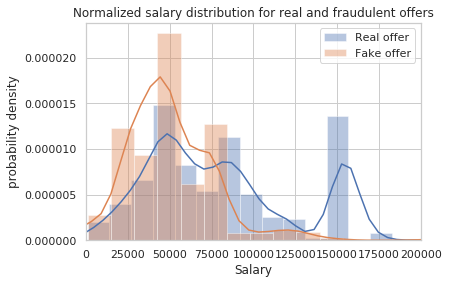

In [82]:


sns.distplot(real_us[['salary_avg_usd']], hist=True, rug=False, label="Real offer", kde=True, norm_hist=True).set_title('Normalized salary distribution for real and fraudulent offers')
sns.distplot(frauds_us[['salary_avg_usd']], hist=True, rug=False, label = "Fake offer", kde=True, norm_hist=True).set_xlim(0, 200000)
plt.legend()
plt.xlabel('Salary')
plt.ylabel('probability density')

plt.show()


Text(0.5, 1.0, 'Boxplot of salary by the fraud status')

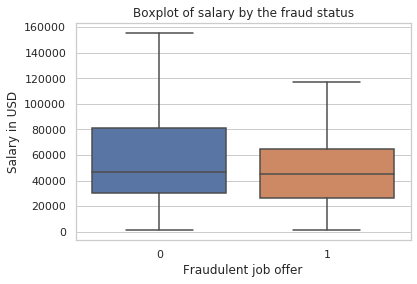

In [83]:
sns.boxplot(x="fraudulent", y="salary_avg_usd",
            data=job_data_cleaned_cats, showfliers=False)
plt.xlabel("Fraudulent job offer")
plt.ylabel("Salary in USD")
plt.title("Boxplot of salary by the fraud status")

us vs rest of the world


In [84]:
us = job_data_cleaned_cats[job_data_cleaned_cats["country"]=="US"]
rest = job_data_cleaned_cats[job_data_cleaned_cats["country"] !="US"]
us.shape, rest.shape

((8361, 31), (6540, 31))

Text(0.5, 1.0, 'Boxplot of salary for US offers by the fraud status')

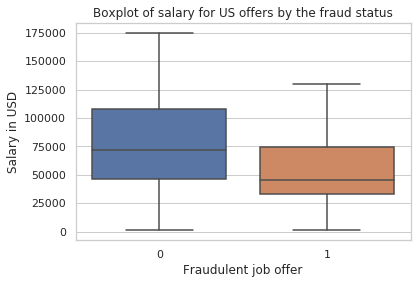

In [85]:
sns.boxplot(x="fraudulent", y="salary_avg_usd",
            data=us, showfliers=False)
plt.xlabel("Fraudulent job offer")
plt.ylabel("Salary in USD")
plt.title("Boxplot of salary for US offers by the fraud status")

Text(0.5, 1.0, 'Boxplot of salary for all countries except USA by the fraud status')

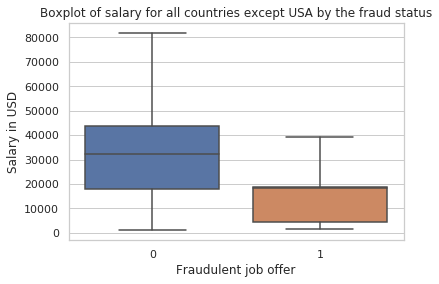

In [86]:
sns.boxplot(x="fraudulent", y="salary_avg_usd",
            data=rest, showfliers=False)
plt.xlabel("Fraudulent job offer")
plt.ylabel("Salary in USD")
plt.title("Boxplot of salary for all countries except USA by the fraud status")

In [87]:
#check if outliers in salary_avg are more prevalent wiht frauds
job_data_cleaned_cats["high_salary"] = [1 if x >150000 else 0 for x in job_data_cleaned_cats['salary_avg_usd']]

In [88]:
job_data_cleaned_cats.groupby(["high_salary", "fraudulent"]).count()["job_id"].rename(columns={"job_id":"count"}).groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

high_salary  fraudulent
0            0             95.306214
             1              4.693786
1            0             98.715348
             1              1.284652
dtype: float64

High salary doesn't seem to play a role in that case.

### Question 4: Are there any specific types of employment used more frequent by scammers in their adverts than others?

In [89]:
job_data_cleaned_cats[job_data_cleaned_cats.fraudulent == 1].groupby(["employment_type"]).count()["job_id"].rename(columns={"job_id":"count"})

employment_type
Contract      32
Full-time    385
Other         10
Part-time     68
Temporary      2
unknown      152
dtype: int64

In [90]:
job_data_cleaned_cats.groupby(["employment_type", "fraudulent"]).count()["job_id"].rename(columns={"job_id":"count"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

employment_type  fraudulent
Contract         0             95.844156
                 1              4.155844
Full-time        0             96.190382
                 1              3.809618
Other            0             95.000000
                 1              5.000000
Part-time        0             90.101892
                 1              9.898108
Temporary        0             99.118943
                 1              0.881057
unknown          0             94.778427
                 1              5.221573
dtype: float64

In [91]:
emp_type_fraud_plot = job_data_cleaned_cats.groupby(["employment_type", "fraudulent"], as_index=False)["job_id"].count().rename(columns={"job_id":"count"})
emp_type_fraud_plot = pd.DataFrame(job_data_cleaned_cats.groupby(["employment_type", "fraudulent"])["job_id"].count()).rename(columns={"job_id":"count"})
emp_type_fraud_plot["percent"] = emp_type_fraud_plot.groupby(level=0).apply(
     lambda x:  100*(x) / x.sum()
)
emp_type_fraud_plot = emp_type_fraud_plot.reset_index()
emp_type_fraud_plot

,employment_type,fraudulent,count,percent
0,Contract,0,738,95.844156
1,Contract,1,32,4.155844
2,Full-time,0,9721,96.190382
3,Full-time,1,385,3.809618
4,Other,0,190,95.000000
5,Other,1,10,5.000000
6,Part-time,0,619,90.101892
7,Part-time,1,68,9.898108
8,Temporary,0,225,99.118943
9,Temporary,1,2,0.881057


Text(0.5, 1, 'Genuine and fraudulent job offers for each employment type')

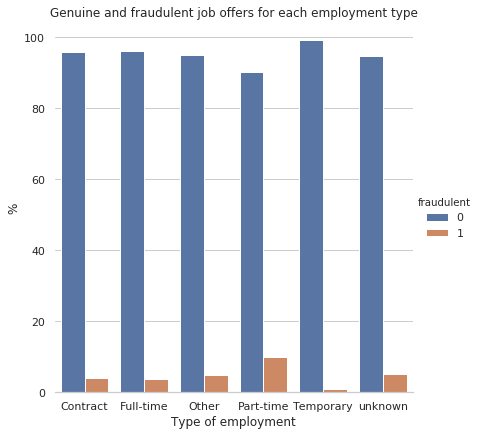

In [92]:
sns.catplot(x="employment_type", y="percent", hue="fraudulent", data=emp_type_fraud_plot,
                height=6, kind="bar").set_xlabels("Type of employment").set_ylabels("%").despine(left=True)

plt.title('Genuine and fraudulent job offers for each employment type')

9% of all Part-time job listings are classified as fraudulent, which is more than 2 times than in case of Full-time jobs. Temporary jobs turned out to contain the lowest relative number of fraudulent postings.

### Question 5. In which industries is the best money?

In [93]:
df = job_data_cleaned_cats[job_data_cleaned_cats["country"] == "US"].groupby(["industry", "fraudulent"], as_index=False)["salary_avg_usd"].mean().round().sort_values(by="salary_avg_usd", ascending=False)
df

,industry,fraudulent,salary_avg_usd
12,Marketing and Advertising,1,219653.0
21,unknown,0,125687.0
13,Oil & Energy,0,117658.0
9,Information Technology and Services,1,104234.0
6,Hospital & Health Care,0,92592.0
8,Information Technology and Services,0,79532.0
10,Internet,0,78877.0
5,Financial Services,1,76542.0
0,Computer Software,0,74456.0
14,Oil & Energy,1,74188.0


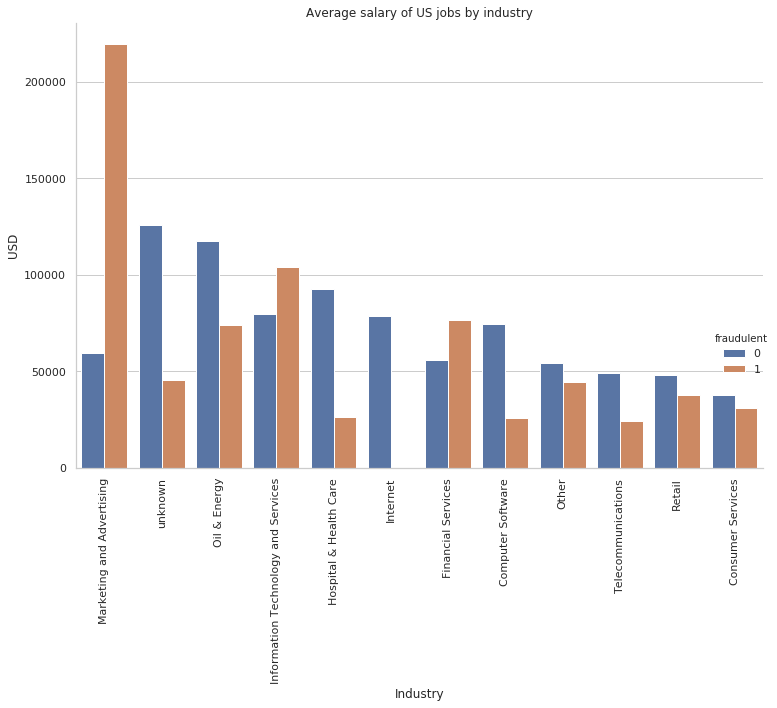

In [94]:
sns.catplot(x="industry", y="salary_avg_usd", hue="fraudulent", data=df,
               height =10,   kind="bar").set_xlabels("Industry").set_ylabels("USD")
plt.title('Average salary of US jobs by industry')
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

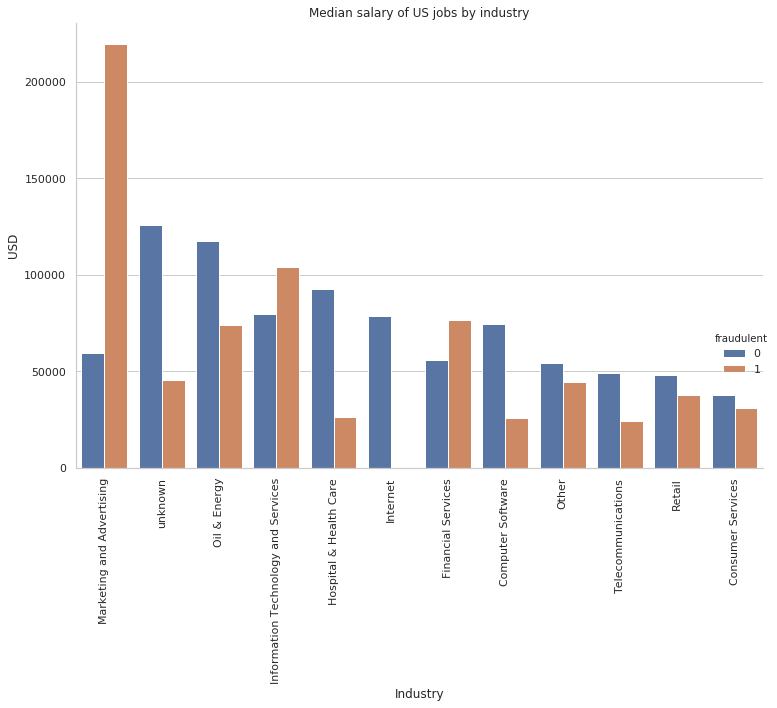

In [95]:
sns.catplot(x="industry", y="salary_avg_usd", hue="fraudulent", data=df,
               height =10,   kind="bar", estimator = np.median).set_xlabels("Industry").set_ylabels("USD")
plt.title('Median salary of US jobs by industry')
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

### Modelling part

In [96]:
relevant_data  = ['job_id', 'telecommuting', 'has_company_logo',
       'has_questions', 'number_offers', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'country',
       'title_length', 'desc_length', 'company_profile_length',
       'requirements_length', 'salary_avg_usd', 'salary_spread', 'mentions_benefits',
        'url_in_desc', 'email_in_desc', 'fraudlike_phrases', 'work_from_home_desc',
       'higher_degree_required', 'high_salary', 'salary_spread_cat']

In [97]:
job_data_to_model = job_data_cleaned_cats[relevant_data]

In [98]:
categoricals = ['employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'country', 'salary_spread_cat']

numerics = ['telecommuting', 'has_company_logo', 'has_questions', 'number_offers', 'title_length', 'desc_length',
           'company_profile_length','requirements_length', 'salary_avg_usd', 'salary_spread', 'mentions_benefits',
           'url_in_desc', 'email_in_desc' 'higher_degree_required', 'high_salary']

In [99]:
job_data_to_model[categoricals].apply(lambda x : len(x.value_counts()))


employment_type         6
required_experience     8
required_education     14
industry               12
function               16
country                 9
salary_spread_cat       4
dtype: int64

In [100]:
job_data_to_model_with_dummies = create_dummy_df(job_data_to_model, categoricals)

In [101]:
job_data_to_model_with_dummies.columns

Index(['job_id', 'telecommuting', 'has_company_logo', 'has_questions',
       'number_offers', 'fraudulent', 'title_length', 'desc_length',
       'company_profile_length', 'requirements_length', 'salary_avg_usd',
       'salary_spread', 'mentions_benefits', 'url_in_desc', 'email_in_desc',
       'fraudlike_phrases', 'work_from_home_desc', 'higher_degree_required',
       'high_salary', 'employment_type_Full-time', 'employment_type_Other',
       'employment_type_Part-time', 'employment_type_Temporary',
       'employment_type_unknown', 'employment_type_nan',
       'required_experience_Director', 'required_experience_Entry level',
       'required_experience_Executive', 'required_experience_Internship',
       'required_experience_Mid-Senior level',
       'required_experience_Not Applicable', 'required_experience_unknown',
       'required_experience_nan', 'required_education_Bachelor's Degree',
       'required_education_Certification', 'required_education_Doctorate',
       'requir

In [102]:
job_data_to_model_with_dummies.head(2)

,job_id,telecommuting,has_company_logo,has_questions,number_offers,fraudulent,title_length,desc_length,company_profile_length,requirements_length,...,country_GR,country_IN,country_NZ,country_Other,country_US,country_nan,salary_spread_cat_low,salary_spread_cat_mid,salary_spread_cat_no spread,salary_spread_cat_nan
0,1,0,1,0,1,0,2,124,141,115,...,0,0,0,0,1,0,1,0,0,0
1,2,0,1,0,1,0,6,315,153,200,...,0,0,1,0,0,0,1,0,0,0


In [103]:
X = job_data_to_model_with_dummies[[c for c in job_data_to_model_with_dummies.columns if c not in ("fraudulent", "job_id")]]

In [104]:
y = job_data_to_model_with_dummies["fraudulent"]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


In [106]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10430, 86), (4471, 86), (10430,), (4471,))

In [107]:
y_train.value_counts()

0    9978
1     452
Name: fraudulent, dtype: int64

Model learned on an inbalanced dataset generalizes poorly, that's why sampling techniques are necessary. For example SMOTE


In [108]:
sm = SMOTE(random_state=23)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [109]:
X_train_res.shape, y_train_res.shape

((19956, 86), (19956,))

In [110]:
y_train_res.value_counts(), 

(1    9978
 0    9978
 Name: fraudulent, dtype: int64,)

In [111]:
y_test.value_counts()

0    4274
1     197
Name: fraudulent, dtype: int64

In [112]:
#Random Forest w/o optimization
rf_model = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = 'sqrt', random_state=23)
# Fit on training data
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [113]:
# Actual class predictions
rf_predictions = rf_model.predict(X_test)


In [114]:
classification_report(y_test, rf_predictions)
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4274
           1       0.86      0.70      0.77       197

    accuracy                           0.98      4471
   macro avg       0.92      0.85      0.88      4471
weighted avg       0.98      0.98      0.98      4471



There are 30% of job postings that haven't been recognized.

Additionaly, precision 0.86 means one in 6 job postings the model classified as fraudulent are in fact normal ones.

In order to achieve better performance more fine tuning of model, additional data, such as E-mail domain, job postings metadata are necessary.


In [115]:
confusion_matrix(y_test, rf_predictions)

array([[4251,   23],
       [  59,  138]])

In [116]:
#plot classification matrix

In [117]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False).reset_index(drop=True)


In [118]:
fi.head(10)

,feature,importance
0,has_company_logo,0.167621
1,salary_avg_usd,0.115623
2,company_profile_length,0.100744
3,has_questions,0.047478
4,required_education_Bachelor's Degree,0.039642
5,country_US,0.036939
6,salary_spread,0.035033
7,requirements_length,0.033071
8,higher_degree_required,0.031700
9,industry_Oil & Energy,0.028235


In [119]:
job_data_cleaned_cats.groupby(["has_company_logo", "fraudulent"])["job_id"].count()

has_company_logo  fraudulent
0                 0              2419
                  1               437
1                 0             11833
                  1               212
Name: job_id, dtype: int64

------------------------------------------------------------------------------------------------------------------
comparison with the "baseline" - if country = USA and salary over 140k then fraud or if country != USA and salary over 80k 

In [120]:
def set_baseline_fraud(df):
    if (df.country == "US" and df.salary_avg_usd > 140000) | (df.country != "US" and df.salary_avg_usd > 80000):
        return 1
    else:
        return 0
    

In [121]:
baseline_df = job_data_cleaned_cats[["country", "salary_avg_usd", "fraudulent"]]
baseline_df.head()

,country,salary_avg_usd,fraudulent
0,US,31898.617886,0
1,NZ,40585.333333,0
2,US,154960.000000,0
3,US,71650.000000,0
4,US,170000.000000,0


In [122]:
baseline_df["baseline_fraud"]=baseline_df.apply(set_baseline_fraud, axis=1)

/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
baseline_df.groupby(["fraudulent", "baseline_fraud"])["country"].count()

fraudulent  baseline_fraud
0           0                 12625
            1                  1627
1           0                   623
            1                    26
Name: country, dtype: int64

In [124]:
print(classification_report(baseline_df.fraudulent, baseline_df.baseline_fraud))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     14252
           1       0.02      0.04      0.02       649

    accuracy                           0.85     14901
   macro avg       0.48      0.46      0.47     14901
weighted avg       0.91      0.85      0.88     14901



In [125]:
confusion_matrix(baseline_df.fraudulent, baseline_df.baseline_fraud)

array([[12625,  1627],
       [  623,    26]])